Alumno: Escobar Sánchez José Alejandro, 19170573

para la materia de Inteligencia Artificial

# Detección de Neumonía empleando CNN

Para la detección de posibles casos de Neumonía a través del análisis de Rx. de Tórax utilizando Redes Neuronales sobre el dataset:

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## Importar utilidades y librerías

In [1]:
import numpy as np
import pandas as pd
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob

from skimage import color, exposure
from sklearn.metrics import classification_report

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed)
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


## Cargar el dataset que he subido a mi Google Drive

Se encuentra en al carpeta 'chest_xray', incluye 5,853 imágenes clasificadas en 'neumonía' y 'normal'.

In [2]:
data_path = '/content/drive/MyDrive/Colab Data/chest_xray/'
data_path

train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'

Se coloca un tamaño de imagen de 200x200 píxeles, para reducir el procesamiento y preservar detalle de la mayoría de los datos. A continuación, se aplica el redimensionado.

In [3]:
img_size = 200

In [4]:
def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])

    images = np.asarray(images)
    return images

In [5]:
train = read_data([train_path])
test = read_data([val_path, test_path])

<ipython-input-4-12f4dc1437f0>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.asarray(images)


Se mezclan los arreglos con las imágenes para obtener resultados más aleatorios y se crean dataframes para la visualización de los datos relacionados a sus etiquetas.

In [6]:
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [7]:
train_df = pd.DataFrame(train, columns = ['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [8]:
train_df['label'].head()

0    PNEUMONIA
1    PNEUMONIA
2       NORMAL
3    PNEUMONIA
4    PNEUMONIA
Name: label, dtype: object

## Visualizar algunos ejemplos del dataset

Se genera una imagen ejemplo con algunas imágenes y sus respectivas labels.

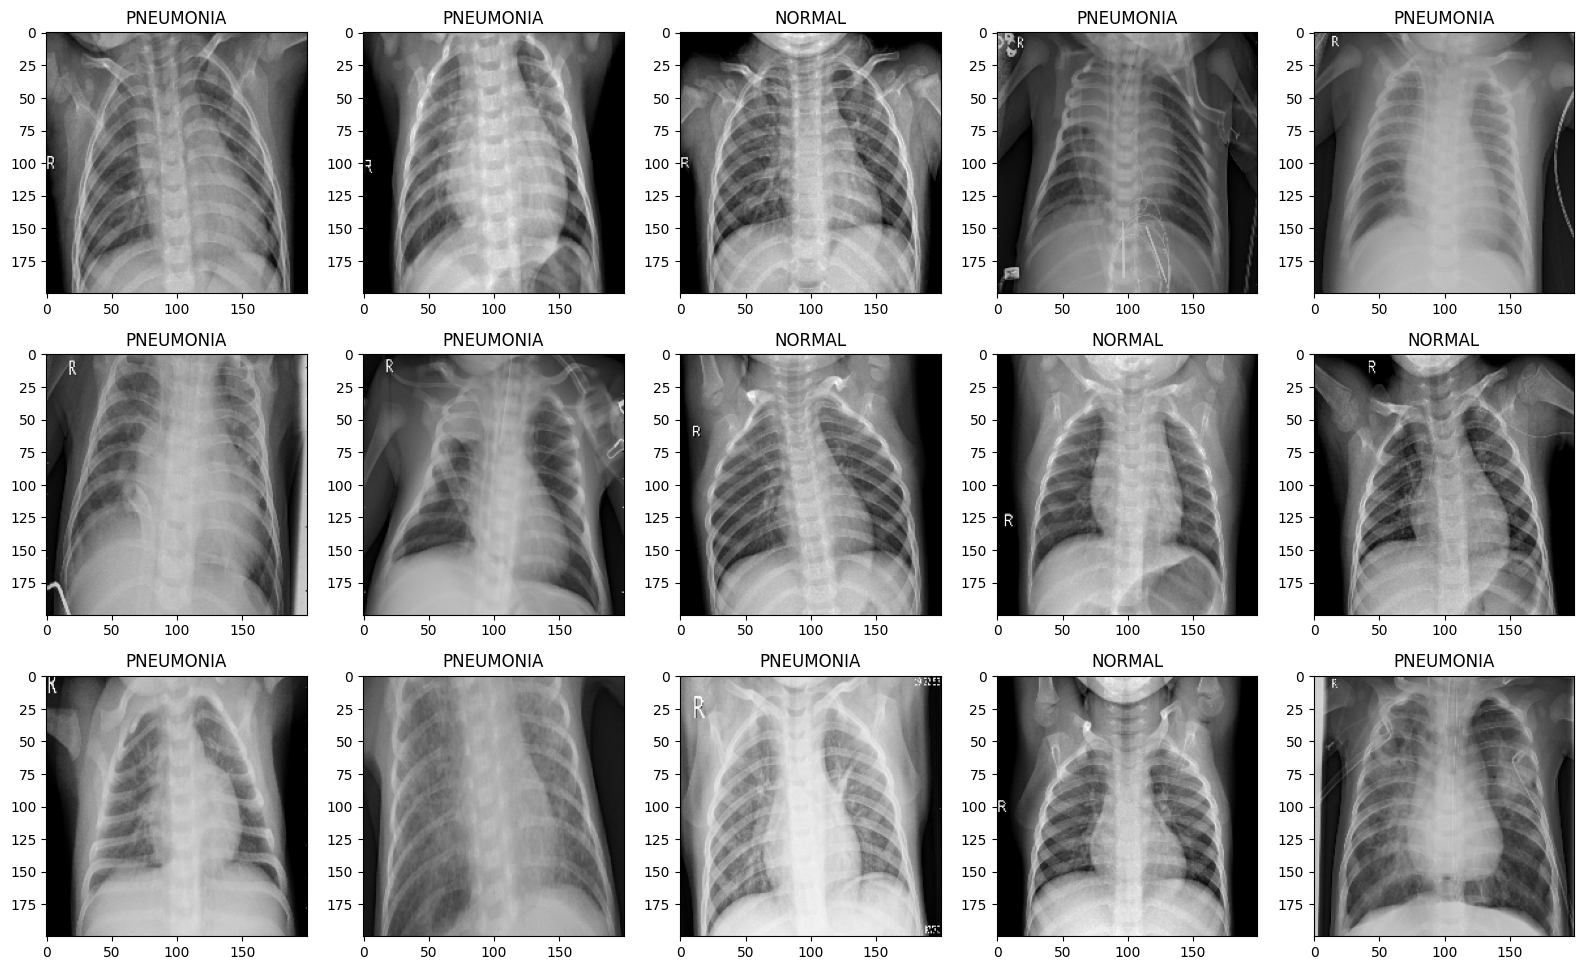

In [9]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))

    plt.tight_layout()

Show_example_image()

Se establece una variable binaria para retornar el estado del pulmón dependiendo de la etiqueta a la que pertenece.

In [10]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

Se dividen los datos en las imágenes de evaluación y sus valores binarios de condición para poder realizar la evaluación del modelo una vez que haya sido generado y entrenado.

In [11]:
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [12]:
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

## Procesamiento de imágenes

Se define un formato GRAYSCALE para eliminar ruido producido por iluminación en las fotografías del dataset.

In [13]:
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [14]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Se dejan dos clases finales para el modelo, que representan pulmones sanos y pulmones con neumonía.

In [15]:
num_classes = y_train.shape[1]
num_classes

2

Después, se asegura de que las imágenes de entrada al modelo llevan el formato correcto. Adicionalmente, usando ImageDataGenerator se pueden alterar los formatos de las imágenes con mayor profundidad. En este caso, no se les aplicaron mayores modificaciones que ligeras rotaciones y un poco de variación en el nivel de zoom.

In [16]:
input_shape = (img_size, img_size, 1)

In [17]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

## Definir el modelo CNN

Se crea el modelo de CNN utilizando ReLu para las capas convolucionales y reduciéndose a capas densas mediante Flatten, para obtener al final un resultado binario apoyándose en el optimizador Adam.

In [18]:
def get_modelcnn():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Flatten(),

        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation = "softmax")

    ])

In [19]:
model = get_modelcnn()
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 16)      2320      
                                                                 
 batch_normalization (Batch  (None, 200, 200, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 100, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      4

## Entrenar el modelo CNN

Se han definido pocas épocas para acortar el tiempo de ejecución. El modelo puede alcanzar una precisión mayor a 90% después de 4 ó 5 épocas de entrenamiento.

In [21]:
learning_history = model.fit_generator((train_gen),
                               epochs = 20,
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test)
                        )

Epoch 1/20


<ipython-input-21-23d86b5637ad>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  learning_history = model.fit_generator((train_gen),


163/163 [==============================] - 28s 171ms/step - loss: 0.2455 - accuracy: 0.9103 - val_loss: 7.3528 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 25s 152ms/step - loss: 0.2167 - accuracy: 0.9166 - val_loss: 6.2679 - val_accuracy: 0.6250
Epoch 3/20
163/163 [==============================] - 30s 185ms/step - loss: 0.1782 - accuracy: 0.9348 - val_loss: 3.9112 - val_accuracy: 0.6250
Epoch 4/20
163/163 [==============================] - 25s 155ms/step - loss: 0.1816 - accuracy: 0.9308 - val_loss: 1.8259 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 27s 166ms/step - loss: 0.1592 - accuracy: 0.9427 - val_loss: 1.4081 - val_accuracy: 0.5385
Epoch 6/20
163/163 [==============================] - 26s 160ms/step - loss: 0.1556 - accuracy: 0.9429 - val_loss: 0.7457 - val_accuracy: 0.7612
Epoch 7/20
163/163 [==============================] - 28s 170ms/step - loss: 0.1390 - accuracy: 0.9471 - val_loss: 0.4074 - val_accuracy: 0.8